# Trend Classification with LSTM

### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'

# 1.0 Load data

## 1.1 Load stock data

In [3]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [4]:
traditional_energy_stocks = [ "LNG", "OKE", "BKR", "WMB", "EQT",  "XEC",  "XOM",  "CVX",  "BP",  "OXY",  "COP",  "EOG",  "COG",  "CNQ",  "SLB",  "PTR",  "TOT",  "ENB"]

In [5]:
data = get_data_yf(traditional_energy_stocks + top_energy, time_period)

[*********************100%***********************]  33 of 33 completed


In [6]:
data.isna().sum().sum()

0

In [7]:
data = process_stock_data_from_yf(data)

In [8]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

## 1.2 Compute technical indicators

In [9]:
all_stock_features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']

In [10]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

## 1.3 Load trends data

In [11]:
filenames = [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [12]:
climate_trends_data = load_climate_data(filenames, terms)

In [13]:
climate_trends_data.shape

(2278, 11)

<AxesSubplot:xlabel='Date'>

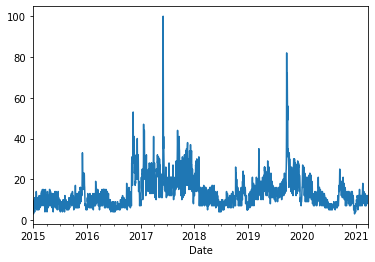

In [14]:
climate_trends_data.set_index('Date')[terms[0]].plot()

### Choose features

In [41]:
chosen_stock_features = all_stock_features

In [42]:
chosen_trend_terms = terms

# 3.0 Model design

In [43]:
num_features = len(chosen_stock_features) + len(chosen_trend_terms) 

In [44]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(5, activation='relu'))
model.add(Dropout(0.25))


model.add(Dense(1, activation='sigmoid'))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 14, 75)            34500     
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 75)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 14, 30)           

# 2.0 Prepare dataset of many stocks

In [46]:
x_train, y_train, x_valid, y_valid, x_test, y_test = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           traditional_energy_stocks + top_energy,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [47]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (23199, 14, 39)
y_train: (23199,)
x_valid: (7656, 14, 39)
y_valid (7656,)
x_test: (7675, 14, 39)
y_test (7675,)


## 2.1 Train on many stocks

In [48]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [50]:
history1 = model.fit(x_train, 
                     y_train, 
                     epochs=15, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
363/363 [==============================] - 16s 31ms/step - loss: 0.6892 - accuracy: 0.5318 - val_loss: 0.7066 - val_accuracy: 0.5293
Epoch 2/15
363/363 [==============================] - 5s 14ms/step - loss: 0.6772 - accuracy: 0.5775 - val_loss: 0.7157 - val_accuracy: 0.5302
Epoch 3/15
363/363 [==============================] - 5s 14ms/step - loss: 0.6687 - accuracy: 0.5944 - val_loss: 0.7003 - val_accuracy: 0.5302
Epoch 4/15
363/363 [==============================] - 5s 14ms/step - loss: 0.6573 - accuracy: 0.6099 - val_loss: 0.6975 - val_accuracy: 0.5307
Epoch 5/15
363/363 [==============================] - 5s 14ms/step - loss: 0.6468 - accuracy: 0.6197 - val_loss: 0.7580 - val_accuracy: 0.5308
Epoch 6/15
363/363 [==============================] - 5s 14ms/step - loss: 0.6445 - accuracy: 0.6341 - val_loss: 0.7362 - val_accuracy: 0.5095
Epoch 7/15
363/363 [==============================] - 5s 14ms/step - loss: 0.6202 - accuracy: 0.6677 - val_loss: 0.7244 - val_accuracy: 0.457

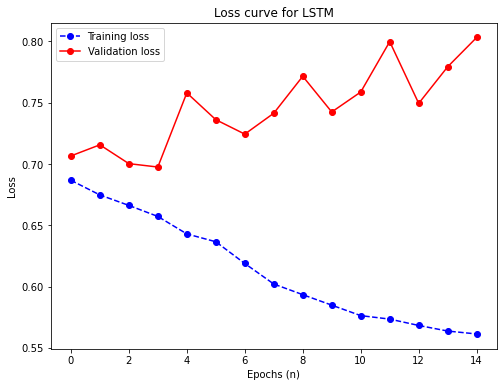

In [51]:
plot_loss(history1)

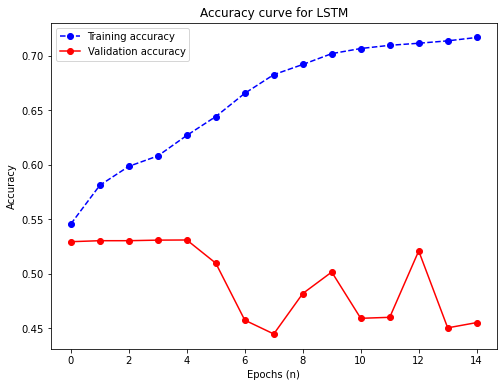

In [52]:
plot_acc(history1)

## 2.2 Performance of model

In [53]:
performance_stats(model, x_train, y_train)

Upward ratio: 50.86%
Mean prediction: 49.40%
Predicted upward ratio: 51.35%
Accuracy: 74.05%


In [54]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 53.02%
Mean prediction: 52.05%
Predicted upward ratio: 50.59%
Accuracy: 45.51%


In [55]:
performance_stats(model, x_test, y_test)

Upward ratio: 47.23%
Mean prediction: 68.95%
Predicted upward ratio: 92.08%
Accuracy: 48.33%


# 3.0 Prepare data for less stocks

In [56]:
x_train2, y_train2, x_valid2, y_valid2, x_test2, y_test2 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           traditional_energy_stocks,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [57]:
print("x_train: {}".format(x_train2.shape))
print("y_train: {}".format(y_train2.shape))
print("x_valid: {}".format(x_valid2.shape))
print("y_valid {}".format(y_valid2.shape))
print("x_test: {}".format(x_test2.shape))
print("y_test {}".format(y_test2.shape))

x_train: (12654, 14, 39)
y_train: (12654,)
x_valid: (4176, 14, 39)
y_valid (4176,)
x_test: (4180, 14, 39)
y_test (4180,)


## 3.1 Train model on less stocks

In [58]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [61]:
history2 = model.fit(x_train2, 
                     y_train2, 
                     epochs=8, 
                     validation_data=(x_valid2, y_valid2), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/8
198/198 [==============================] - 12s 41ms/step - loss: 0.5506 - accuracy: 0.7284 - val_loss: 0.7402 - val_accuracy: 0.4523
Epoch 2/8
198/198 [==============================] - 3s 14ms/step - loss: 0.5430 - accuracy: 0.7377 - val_loss: 0.7822 - val_accuracy: 0.4674
Epoch 3/8
198/198 [==============================] - 3s 14ms/step - loss: 0.5466 - accuracy: 0.7215 - val_loss: 0.7634 - val_accuracy: 0.4593
Epoch 4/8
198/198 [==============================] - 3s 14ms/step - loss: 0.5551 - accuracy: 0.7292 - val_loss: 0.7514 - val_accuracy: 0.4595
Epoch 5/8
198/198 [==============================] - 3s 14ms/step - loss: 0.5448 - accuracy: 0.7342 - val_loss: 0.7696 - val_accuracy: 0.4466
Epoch 6/8
198/198 [==============================] - 3s 14ms/step - loss: 0.5439 - accuracy: 0.7348 - val_loss: 0.7692 - val_accuracy: 0.4557
Epoch 7/8
198/198 [==============================] - 3s 14ms/step - loss: 0.5354 - accuracy: 0.7397 - val_loss: 0.7508 - val_accuracy: 0.5144
Epoch

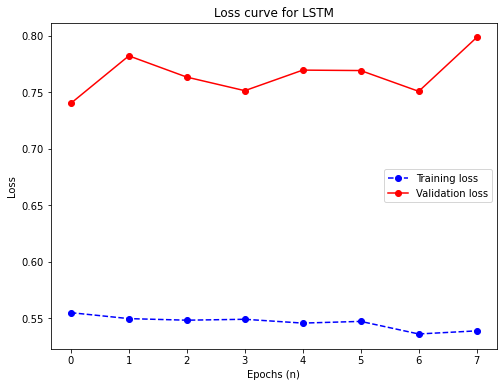

In [62]:
plot_loss(history2)

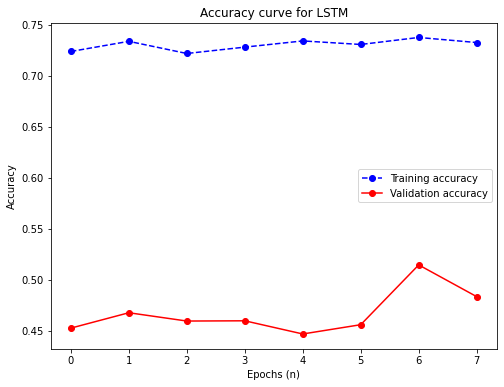

In [63]:
plot_acc(history2)

## 3.2 Performance of model

In [64]:
performance_stats(model, x_train2, y_train2)

Upward ratio: 49.73%
Mean prediction: 49.00%
Predicted upward ratio: 50.57%
Accuracy: 75.33%


In [65]:
performance_stats(model, x_valid2, y_valid2)

Upward ratio: 52.85%
Mean prediction: 52.50%
Predicted upward ratio: 59.79%
Accuracy: 48.32%


In [66]:
performance_stats(model, x_test2, y_test2)

Upward ratio: 47.03%
Mean prediction: 68.67%
Predicted upward ratio: 91.53%
Accuracy: 45.26%
